<a href="https://colab.research.google.com/github/jainilparikh/NeuralArtTransfer/blob/master/neutalArtTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from flask import Flask
import numpy as np
import cv2
import tensorflow as tf;
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from google.colab import files

content_img = files.upload()

Saving content.jpg to content.jpg


In [9]:
from google.colab import files
styleImage = files.upload()

Saving style.jpg to style.jpg


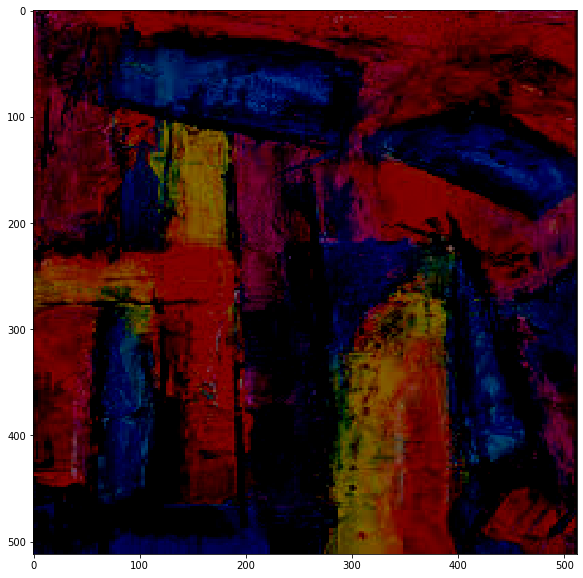

In [10]:
def get_image(imgpath):
    w=512
    h=512
    loaded_img = tf.keras.preprocessing.image.load_img(imgpath,target_size=(w,h))
   
    image = tf.keras.applications.vgg19.preprocess_input(tf.keras.preprocessing.image.img_to_array(loaded_img))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image , axis = 0)
    return image
def imgshow(image):
    image[:,:,0]  *=64/255.0
    image[:,:,1] *=128/255.0
    image[:,:,2] *=192/255.0
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8')
    img=np.squeeze(image)
    plt.figure(figsize = (50,10))
    plt.imshow(img, interpolation='nearest')
def imshowImage(image):
  image[:,:,0]  *=64/255.0
  image[:,:,1] *=128/255.0
  image[:,:,2] *=192/255.0
  image = image[:,:,::-1]
  image = np.clip(image,0,255).astype('uint8')
  img=np.squeeze(image)
  return img
styleImage = get_image("/content/style.jpg")
contentImage = get_image("/content/content.jpg")
imgshow(styleImage)


In [11]:
from tensorflow.keras.applications.vgg19 import VGG19

# Layer Extraction From VGG Model 

In [12]:
baseModel = VGG19(weights='imagenet',include_top=False,pooling='Max');
baseModel.trainable = False;
contentImageLayers = ['block5_conv2']
styleImageLayers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
baseModel.get_layer(contentImageLayers[0])
print(baseModel.input)

80142336/80134624 [==============================] - 1s 0us/step
Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


#Model Prep

In [13]:
contentModel = Model(inputs = baseModel.input,outputs = baseModel.get_layer(contentImageLayers[0]).output) 

In [14]:
styleModel = [Model(inputs = baseModel.input , outputs = baseModel.get_layer(Layer).output) for Layer in styleImageLayers]

# Content Loss

In [15]:
def customLoss(model,inputImage,outputImage):
  val = tf.reduce_mean((model(inputImage) - model(outputImage))**2)
  return val;

# GRAM Matrix ( For Style Loss)

In [16]:
def gramMatrix(inputImage):
  channels=int(inputImage.shape[-1])
  a=tf.reshape(inputImage,[-1,channels])
  n=tf.shape(a)[0]
  gram=tf.matmul(a,a,transpose_a=True)
  return(gram/tf.cast(n,tf.float32))

# Style Loss

In [17]:
def styleLoss(model,inputImage,generated):
  error = 0
  for styleModels in model:
    styleVal = styleModels(inputImage);
    generatedVal = styleModels(generated)
    val = tf.reduce_mean((gramMatrix(styleVal) - gramMatrix(generatedVal))**2);
    error = error + val*1/len(model);
  return error;

# Training the Initial Image with Content and Style Images

In [18]:
def runFunction(contentImage,styleImage):
  ## Calculate loss for content image
  ## Calculate loss for style image
  ## update the initial image by the error from the losses calculated
  ## repeat the process
  contentGenerated = tf.Variable(contentImage,dtype = tf.float32);
  optimizer = tf.keras.optimizers.Adam(learning_rate = 10)
  maxImage = contentGenerated;
  maxCost = 1e12

  ## Weighted Loss calcualtion
  for i in range(0,500):
    print('Iteration : ' + str(i))
    with tf.GradientTape() as tape:
      contentLossVal = customLoss(contentModel,contentImage,contentGenerated)
      styleLossVal = styleLoss(styleModel , styleImage , contentGenerated)
      cost = contentLossVal * 40 + styleLossVal * 1000;
      gradient = tape.gradient(cost , contentGenerated);
      optimizer.apply_gradients([(gradient,contentGenerated)])
      print(cost)
      if(cost < maxCost):
        maxCost = cost;
        maxImage = contentGenerated.numpy();
  return maxImage,contentGenerated.numpy();

In [19]:
img,imgVal = runFunction(contentImage,styleImage)

Iteration : 0
tf.Tensor(34631200000000.0, shape=(), dtype=float32)
Iteration : 1
tf.Tensor(19076376000000.0, shape=(), dtype=float32)
Iteration : 2
tf.Tensor(12933690000000.0, shape=(), dtype=float32)
Iteration : 3
tf.Tensor(10532116000000.0, shape=(), dtype=float32)
Iteration : 4
tf.Tensor(9289303000000.0, shape=(), dtype=float32)
Iteration : 5
tf.Tensor(7545414000000.0, shape=(), dtype=float32)
Iteration : 6
tf.Tensor(6196630000000.0, shape=(), dtype=float32)
Iteration : 7
tf.Tensor(5094354000000.0, shape=(), dtype=float32)
Iteration : 8
tf.Tensor(4437391700000.0, shape=(), dtype=float32)
Iteration : 9
tf.Tensor(3955976800000.0, shape=(), dtype=float32)
Iteration : 10
tf.Tensor(3665991800000.0, shape=(), dtype=float32)
Iteration : 11
tf.Tensor(3291901000000.0, shape=(), dtype=float32)
Iteration : 12
tf.Tensor(3006042700000.0, shape=(), dtype=float32)
Iteration : 13
tf.Tensor(2740260000000.0, shape=(), dtype=float32)
Iteration : 14
tf.Tensor(2520742600000.0, shape=(), dtype=float32)
I

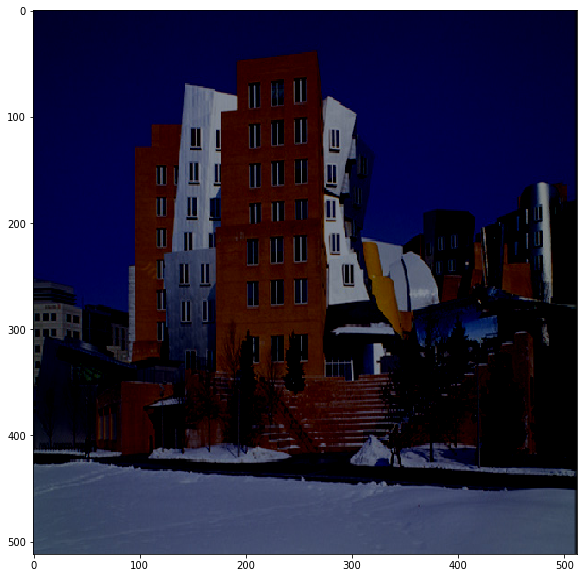

In [20]:
## Original Image

imgshow(contentImage)

# Result Image

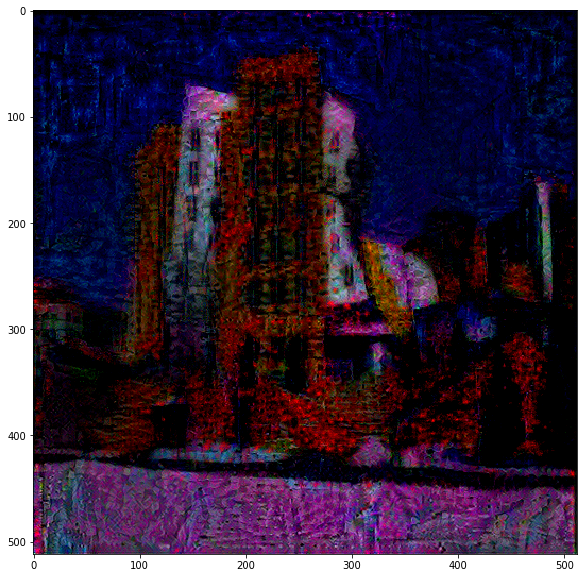

In [21]:
imgshow(imgVal)

In [22]:
!pip install flask-ngrok

In [ ]:
## FLASK
##  Hosted on ngrok :: http://f211c07033ea.ngrok.io
import io
from PIL import Image
import os
from flask import request, Response
from flask import render_template
from flask import send_file
from flask_ngrok import run_with_ngrok


folder = "/content/templates";
resImage = imgVal;
app = Flask(__name__)
app.config['folder'] = folder
run_with_ngrok(app)  ## Start ngork

@app.route('/',methods = ['POST' , 'GET'])

## Sending Image to the server
def neuralArt():
  content_type = 'image/jpeg'
  file_object = io.BytesIO()
  img = imshowImage(resImage);
  img = Image.fromarray(img.astype('uint8'))
  img.save(file_object, 'jpeg')
  file_object.seek(0)
  return send_file(file_object , mimetype = 'image/jpeg')

## Getting image from the client


@app.route('/imageInput' , methods = ['POST' ,'GET'])
def getImage():
  print(request.method);
  if(request.method == 'POST'):
    print("This is athis sia");
    file = request.files['styleImage']
    print(file)
    if file:
      filename = file.filename
      print(filename)
      file.save(os.path.join(app.config['folder'], filename))
      print("The file is saved")
    for i in request.files:
      print(i)
    file = request.files['contentImage']
    print(file)
    if file:
      filename = file.filename
      print(filename)
      file.save(os.path.join(app.config['folder'], filename))
      print("The file is saved")
    print("this si a");


    contentImage = get_image("/content/templates/content.jpg")
    styleImage = get_image("/content/templates/style.jpg")


    _ , resImage = runFunction(contentImage,styleImage)
    ## Somehow we need to show this image 
    return "";
  else:
    return render_template('imageUpload.html')

if __name__ == '__main__':
  app.run()
  

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://04ff4893d5dd.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Oct/2020 10:06:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2020 10:06:05] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [20/Oct/2020 10:06:10] "GET /imageInput HTTP/1.1" 200 -


GET
POST
This is athis sia
<FileStorage: 'style.jpg' ('image/jpeg')>
style.jpg
The file is saved
styleImage
contentImage
<FileStorage: 'content.jpg' ('image/jpeg')>
content.jpg
The file is saved
this si a
Iteration : 0
tf.Tensor(35356720000000.0, shape=(), dtype=float32)
Iteration : 1
tf.Tensor(19529130000000.0, shape=(), dtype=float32)
Iteration : 2
tf.Tensor(13222209000000.0, shape=(), dtype=float32)
Iteration : 3
tf.Tensor(10708533000000.0, shape=(), dtype=float32)
Iteration : 4
tf.Tensor(9424227000000.0, shape=(), dtype=float32)
Iteration : 5
tf.Tensor(7696377000000.0, shape=(), dtype=float32)
Iteration : 6
tf.Tensor(6310501000000.0, shape=(), dtype=float32)
Iteration : 7
tf.Tensor(5183990400000.0, shape=(), dtype=float32)
Iteration : 8
tf.Tensor(4525186400000.0, shape=(), dtype=float32)
Iteration : 9
tf.Tensor(4052939400000.0, shape=(), dtype=float32)
Iteration : 10
tf.Tensor(3731034700000.0, shape=(), dtype=float32)
Iteration : 11
tf.Tensor(3368782700000.0, shape=(), dtype=float3